<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Формулы метрик качества:
- $sMAPE = \dfrac{1}{N} \sum\limits_{i=1}^n \dfrac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|) / 2} \cdot 100 \% $
- ${sMAPE\;total} = 0.25 \cdot{sMAPE\;rougher} + 0.75 \cdot{sMAPE\;final}$


#### Описание данных

__Технологический процесс__

* Rougher feed — исходное сырье
    - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant 
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота


__Параметры этапов__
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

#### Наименование признаков

Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока [этап]:

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

## Подготовка данных

In [980]:
# импортируем библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

import matplotlib.pyplot as plt 
import numpy as np

import plotly
from plotly.offline import plot, iplot
import plotly.graph_objs as go


# чтобы игнорировать ошибки
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns


#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8


In [981]:
# загрузим дадасет
try:
    df_train = pd.read_csv('/Users/gazizovilsur26/Downloads/gold_recovery_train_new.csv',
                           index_col='date', parse_dates=True)
    df_test = pd.read_csv('/Users/gazizovilsur26/Downloads/gold_recovery_test_new.csv',
                          index_col='date', parse_dates=True)
    df_full = pd.read_csv('/Users/gazizovilsur26/Downloads/gold_recovery_full_new.csv',
                          index_col='date', parse_dates=True)
except:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv',
                           index_col='date', parse_dates=True)
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv',
                          index_col='date', parse_dates=True)
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv',
                          index_col='date', parse_dates=True)

In [982]:
# чтобы выводились все столбцы
pd.set_option('display.max_columns', None)
# выведем первые 5 строк дадасетов
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [983]:
display(df_test.head())

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [984]:
display(df_full.head())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [985]:
# выведм общую информацию по тренировочной выборке
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

In [986]:
# выведм общую информцию про тестовую выбоку
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [987]:
# выведем общую информацию про исходный сырые данные
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

#### 1.2 Проверим, что эффективность обогащения рассчитана правильно

Вычислим её на обучающей выборке для признака rougher.output.recovery.  Найдите MAE между вашими расчётами и значением признака

In [988]:
# посчитаем recovery самостоятельно и сравним со значениями в столбце rougher.output.recovery, посчитав MAE
print(' MAE между нашими расчётами rougher.output.recovery и значением признака',
      mean_absolute_error(df_train['rougher.output.recovery'], (df_train['rougher.output.concentrate_au']\
                                           * (df_train['rougher.input.feed_au']\
                            - df_train['rougher.output.tail_au']) / (df_train['rougher.input.feed_au']\
                            * (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au']))\
                            * 100)).round(2))


 MAE между нашими расчётами rougher.output.recovery и значением признака 0.0


Вывод: MAE равен 0, Recovery подсчитано правильно

#### 1.2. Проанализируем признаки, недоступные в тестовой выборке 

In [989]:
# получим отсутствующие в тестовой выборке столбцы и потом выведем их на экран
columns_missed = set(df_train.columns) - set(df_test.columns)
columns_missed

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Вывод:
* output - выходные данные, а не исходные
* calculation -  подразумевает расчётные характеристики

Удаляем все, но перед обучением после полного анализа

#### Проверим тренировочную выборку на явные дубликаты

In [990]:
print('Количество явных дубликатов:' ,df_train.duplicated().sum())

Количество явных дубликатов: 0


Промежуточный вывод: 
* названия всех столбцов соответсвуют змеиному регистру
* есть пропуски
* явных дубликатов нет
* в тестовой выборке отсутствуют 36 признаков, которые есть в тренировочной. Удалим их из тренировочной, оставив только целевые признаки final.output.recovery, rougher.output.recovery. Также добавим эти 2 столбца в тестовую выборку из из исходного датафрейма df_full, но сделаем это после прведения полного анализа

#### Заполнение пропусков

После анализа датасета видно, что значения признаков зависят от времени. Соседние по времени объекты имеют похожие значения. Поэтому заполним пропуски методом `interpolate()`, который вместо пропущенного значения вставляет среднее соседних значений

In [991]:
# заменим пропуски средним значением соседних объектов
df_train = df_train.interpolate()

In [992]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                     

Вывод:
* В тренировочном датасете 14149 данных
* Дубликатов нет
* В тестовой выборке нет некоторых признаков, которые есть в тренировочной. Будем работать без них, потому что эти признаки являются выходными данными типа output. Но удалим эти столбцы после полного анализа
* С названиями столбцов проблем нет, все в змеином регистре
* Столбец date сделали индексом, в том числе переведя в тип данных datetime
* Между соседними (по времени) входными данными наблюдается зависимость: близкие по времени строки имеют близкие значения одних и тех же признаков. Поэтому мы интерполировали пропуски средним арифметическим двух соседних строк



## Анализ данных

#### 2.1 Посмотрим, как меняется концентрация металлов (Au, Ag, Pb)  на различных этапах очистки

In [993]:
# отберём в списки столбцы с концентрациями на различных этапах для каждого металла отдельно 
columns_au = []
columns_ag = []
columns_pb = []
for i in range(len(df_train.columns)):
    if 'concentrate_au' in df_train.columns[i]:
        columns_au.append(df_train.columns[i])
    elif 'concentrate_ag' in df_train.columns[i]:
        columns_ag.append(df_train.columns[i])
    elif 'concentrate_pb' in df_train.columns[i]:
        columns_pb.append(df_train.columns[i])
columns_au.append('rougher.input.feed_au')
columns_ag.append('rougher.input.feed_ag')   
columns_pb.append('rougher.input.feed_pb')   

In [994]:
columns_au = columns_au[::-1]
columns_au

['rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'final.output.concentrate_au']

In [995]:
columns_ag = columns_ag[::-1]
columns_ag

['rougher.input.feed_ag',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_ag',
 'final.output.concentrate_ag']

In [996]:
columns_pb = columns_pb[::-1]
columns_pb

['rougher.input.feed_pb',
 'rougher.output.concentrate_pb',
 'primary_cleaner.output.concentrate_pb',
 'final.output.concentrate_pb']

In [997]:
# усредним значения по кадлому столбцу, чтобы потом построить график
df_au_mean = df_train[columns_au].mean()
df_ag_mean = df_train[columns_ag].mean()
df_pb_mean = df_train[columns_pb].mean()
display(df_au_mean)
display(df_ag_mean)
display(df_pb_mean)

rougher.input.feed_au                     7.866577
rougher.output.concentrate_au            19.439958
primary_cleaner.output.concentrate_au    32.386836
final.output.concentrate_au              44.003792
dtype: float64

rougher.input.feed_ag                     8.579195
rougher.output.concentrate_ag            11.775812
primary_cleaner.output.concentrate_ag     8.200916
final.output.concentrate_ag               5.141918
dtype: float64

rougher.input.feed_pb                     3.505983
rougher.output.concentrate_pb             7.664555
primary_cleaner.output.concentrate_pb     9.568501
final.output.concentrate_pb              10.132845
dtype: float64

In [998]:
# столбчатые диаграммы

# создаем traces для визуализации
trace0 = go.Bar(
    x=df_au_mean.index,
    y=df_au_mean,
    name='au'
)

trace1 = go.Bar(
    x=df_ag_mean.index,
    y=df_ag_mean,
    name='ag'
)

trace2 = go.Bar(
    x=df_pb_mean.index,
    y=df_pb_mean,
    name='pb'
)

# создаем массив с данными и задаем title для графика и оси x в layout
data = [trace0, trace1, trace2]
layout = {'title': 'Средняя по всем данным концентрация Au, Ag, Pb','yaxis': {'title': 'Концентрация'}}

# создаем объект Figure и визуализируем его
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

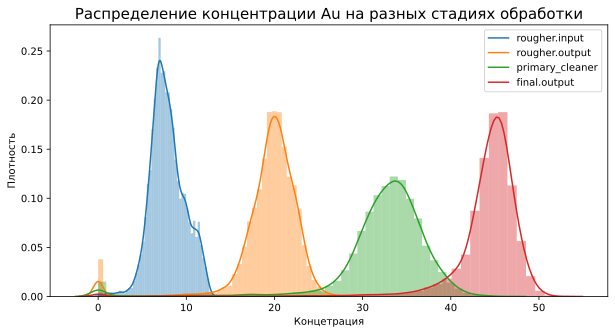

In [999]:
# построим распределение концентрации Au на разных стадиях обработки с помощью библиотеки seaborn
plt.figure(figsize=(10,5))

sns.distplot(df_train['rougher.input.feed_au'], kde_kws= {"label": "rougher.input"})
sns.distplot(df_train['rougher.output.concentrate_au'], kde_kws= {"label": "rougher.output"})
sns.distplot(df_train['primary_cleaner.output.concentrate_au'], kde_kws= {"label": "primary_cleaner"})
sns.distplot(df_train['final.output.concentrate_au'], kde_kws= {"label": "final.output"})
plt.legend(bbox_to_anchor=(0.77, 1), loc=2)
plt.xlabel('Концетрация')
plt.ylabel('Плотность')
plt.title(label='Распределение концентрации Au на разных стадиях обработки', fontsize=15);


Есть выбросы, удалим их  

In [1000]:
df_train['rougher.input.feed_au'].describe()

count    14149.000000
mean         7.866577
std          1.919506
min          0.010000
25%          6.596217
50%          7.649138
75%          9.066976
max         13.126043
Name: rougher.input.feed_au, dtype: float64

In [1001]:
def outliers_delete(data, columns):
    for column in columns:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = abs(q3 - q1)
        data = data[(data[column] > (q1 - (4 * iqr)))
                        & (data[column] < (q3 + (4 * iqr)))]
    return data


In [1002]:
df_train = outliers_delete(df_train, columns_au)

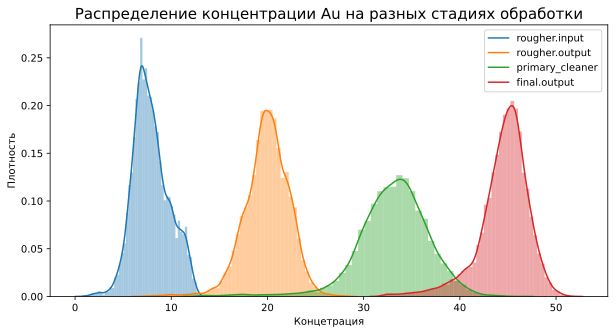

In [1003]:
# построим распределение концентрации Au на разных стадиях обработки с помощью библиотеки seaborn
plt.figure(figsize=(10,5))

sns.distplot(df_train['rougher.input.feed_au'], kde_kws= {"label": "rougher.input"})
sns.distplot(df_train['rougher.output.concentrate_au'], kde_kws= {"label": "rougher.output"})
sns.distplot(df_train['primary_cleaner.output.concentrate_au'], kde_kws= {"label": "primary_cleaner"})
sns.distplot(df_train['final.output.concentrate_au'], kde_kws= {"label": "final.output"})
plt.legend(bbox_to_anchor=(0.77, 1), loc=2)
plt.xlabel('Концетрация')
plt.ylabel('Плотность')
plt.title(label='Распределение концентрации Au на разных стадиях обработки', fontsize=15);

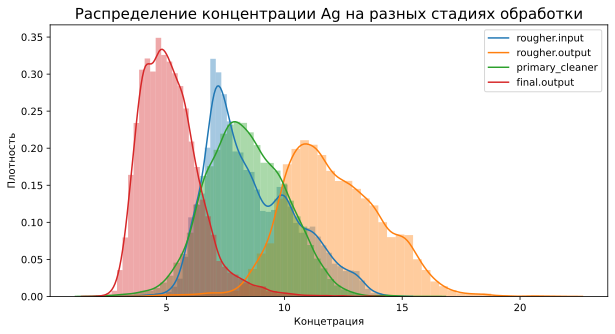

In [1004]:
# построим распределение концентрации Ag на разных стадиях обработки с помощью библиотеки seaborn
plt.figure(figsize=(10,5))

sns.distplot(df_train['rougher.input.feed_ag'], kde_kws= {"label": "rougher.input"})
sns.distplot(df_train['rougher.output.concentrate_ag'], kde_kws= {"label": "rougher.output"})
sns.distplot(df_train['primary_cleaner.output.concentrate_ag'], kde_kws= {"label": "primary_cleaner"})
sns.distplot(df_train['final.output.concentrate_ag'], kde_kws= {"label": "final.output"})
plt.legend(bbox_to_anchor=(0.77, 1), loc=2)
plt.xlabel('Концетрация')
plt.ylabel('Плотность')
plt.title(label='Распределение концентрации Ag на разных стадиях обработки', fontsize=15);

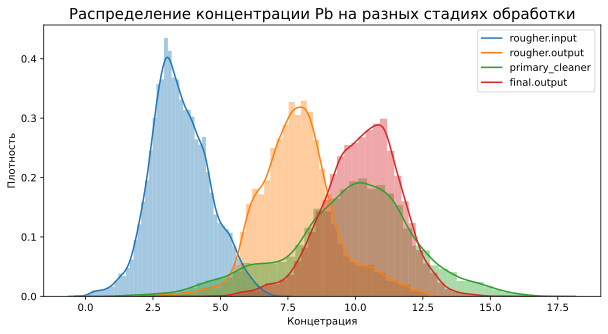

In [1005]:
# построим распределение концентрации Pb на разных стадиях обработки с помощью библиотеки seaborn
plt.figure(figsize=(10,5))

sns.distplot(df_train['rougher.input.feed_pb'], kde_kws= {"label": "rougher.input"})
sns.distplot(df_train['rougher.output.concentrate_pb'], kde_kws= {"label": "rougher.output"})
sns.distplot(df_train['primary_cleaner.output.concentrate_pb'], kde_kws= {"label": "primary_cleaner"})
sns.distplot(df_train['final.output.concentrate_pb'], kde_kws= {"label": "final.output"})
plt.legend(bbox_to_anchor=(0.77, 1), loc=2)
plt.xlabel('Концетрация')
plt.ylabel('Плотность')
plt.title(label='Распределение концентрации Pb на разных стадиях обработки', fontsize=15);

Вывод:
* Изначально в распределении концентрации Au на всех этапах обработки были выбросы. Удалили. 
* Концентрация золота в концентрате после каждого этапа обработки увеличвается, доходя до значения 44 в среднем после финальной очистки. Всё логично, ведь мы хотим получить золото из руды, в конце мы должны получить как можно более чистое золото
* Концентрация серебра в концентрате после каждого этапа обработки уменьшается. Значит руда ощищается, всё логично
* Концентрация свинца в концентрате после каждого этапа обработки увеличивается. Но его концентрация относительно золота уменьшается практически в 2 раза

#### 2.2 Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.  Если распределения сильно отличаются друг от друга, оценка модели будет  неправильной

Если распределения будут различаться на трейн и тест, то значит выборки составлены неверно, нужно разбираться почему так случилось. Если востановить нормальные значения признака на тесте не получится, то это признак потребуется исключить. Тут идея простая - данные, на которых обучаем модель и на которых проверяем ее, должны быть максимально похожи по своей природе (по распределению, которое их порождает)

In [1006]:
# выведем на экран названия столбцов, содержащих информацию про размеры гранул
columns_size = []
for i in range(len(df_train.columns)):
    if 'size' in df_train.columns[i]:
        columns_size.append(df_train.columns[i])
        print(df_train.columns[i])


primary_cleaner.input.feed_size
rougher.input.feed_size


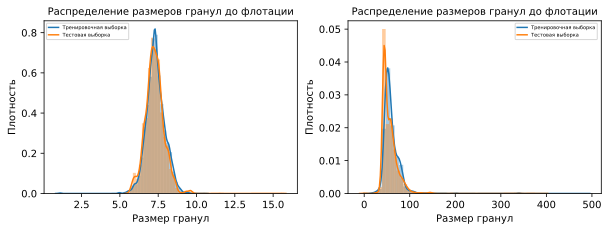

In [1007]:
# построим распределения distplot из библиотеки seaborn

plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
sns.distplot(df_train['primary_cleaner.input.feed_size'], kde_kws= {"label": "Тренировочная выборка"})
sns.distplot(df_test['primary_cleaner.input.feed_size'], kde_kws= {"label": "Тестовая выборка"})
plt.legend(bbox_to_anchor=(0, 1), loc=2, fontsize=5)
plt.title(label='Распределение размеров гранул до флотации', fontsize=10)
plt.xlabel('Размер гранул')
plt.ylabel('Плотность')

plt.subplot(2,2,2)
sns.distplot(df_train['rougher.input.feed_size'], kde_kws= {"label": "Тренировочная выборка"})
sns.distplot(df_test['rougher.input.feed_size'], kde_kws= {"label": "Тестовая выборка"})


plt.legend(bbox_to_anchor=(0.65, 1), loc=2, fontsize=5)
plt.xlabel('Размер гранул')
plt.ylabel('Плотность')
plt.title(label='Распределение размеров гранул до флотации', fontsize=10);

Вывод: Распределения размеров гранул для тестовой и тренировочной выборок не отличаются друг от друг. Всё хорошо, распределения по природе своей не отличаются. Можно работать 

#### 2.3 Исследуем суммарную концентрацию всех веществ на разных стадиях:  в сырье, в черновом и финальном концентратах

In [1008]:
final_output_concentrate = pd.Series(df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_pb']
                            + df_train['final.output.concentrate_sol'] + df_train['final.output.concentrate_au'])
primary_cleaner_concentrate = pd.Series(df_train['primary_cleaner.output.concentrate_ag']
                                        + df_train['primary_cleaner.output.concentrate_pb']
                                        + df_train['primary_cleaner.output.concentrate_sol']
                                       + df_train['primary_cleaner.output.concentrate_au'])
rouhger_output_concentrate = pd.Series(df_train['rougher.output.concentrate_ag']
                                      + df_train['rougher.output.concentrate_pb']
                                      + df_train['rougher.output.concentrate_sol']
                                      + df_train['rougher.output.concentrate_au'])
rouhger_input_concentrate = pd.Series(df_train['rougher.input.feed_ag']
                                     + df_train['rougher.input.feed_pb']
                                     + df_train['rougher.input.feed_sol']
                                     + df_train['rougher.input.feed_au'])


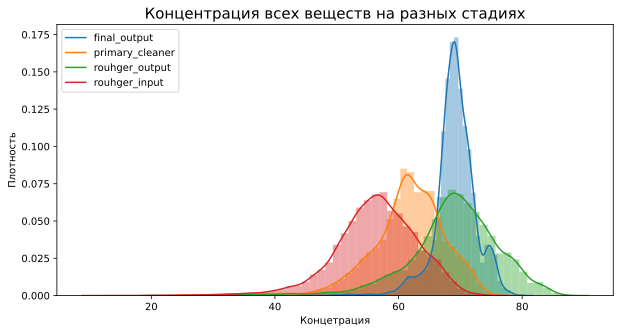

In [1009]:
plt.figure(figsize=(10,5))

sns.distplot(final_output_concentrate, kde_kws= {"label": "final_output"})
sns.distplot(primary_cleaner_concentrate, kde_kws= {"label": "primary_cleaner"})
sns.distplot(rouhger_output_concentrate, kde_kws= {"label": "rouhger_output"})
sns.distplot(rouhger_input_concentrate, kde_kws= {"label": "rouhger_input"})
plt.legend(bbox_to_anchor=(0, 1), loc=2)
plt.xlabel('Концетрация')
plt.ylabel('Плотность')
plt.title(label='Концентрация всех веществ на разных стадиях', fontsize=15);

Вывод: 
* Суммарная концентрация веществ увеличивается к финальному этапу. 
* При этом дисперсия их распределения уменьшается
* Выбросов нет

#### Удалим из тренировочного датасета столбцы, которых нет в тестовой

In [1010]:
# удалим из тренировочного датасета столбцы, которых нет в тестовой, потом добавим целевые
# признаки из columns_to_test
columns_to_test = ["final.output.recovery","rougher.output.recovery"]
df_train = df_train.drop(columns_missed, axis=1).join(df_full[columns_to_test])

In [1011]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13295 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               13295 non-null  float64
 1   primary_cleaner.input.depressant            13295 non-null  float64
 2   primary_cleaner.input.feed_size             13295 non-null  float64
 3   primary_cleaner.input.xanthate              13295 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      13295 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    13295 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      13295 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13295 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      13295 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    1329

In [1012]:
# добавим целевые признаки в тестовую выборку
df_test = df_test.join(df_full[columns_to_test])

In [1013]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

#### Разделим выборки для стадий обработок rougher и final

In [1014]:
# соберём признаки, относящиеся к этапу rougher и сохраним их в df_train_rougher
columns_rougher = []
for column in df_train.columns:
    if 'rougher' in column:
        columns_rougher.append(column)
df_train_rougher = df_train[columns_rougher]

In [1015]:
df_train_rougher.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13295 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               13295 non-null  float64
 1   rougher.input.feed_pb               13295 non-null  float64
 2   rougher.input.feed_rate             13295 non-null  float64
 3   rougher.input.feed_size             13295 non-null  float64
 4   rougher.input.feed_sol              13295 non-null  float64
 5   rougher.input.feed_au               13295 non-null  float64
 6   rougher.input.floatbank10_sulfate   13295 non-null  float64
 7   rougher.input.floatbank10_xanthate  13295 non-null  float64
 8   rougher.input.floatbank11_sulfate   13295 non-null  float64
 9   rougher.input.floatbank11_xanthate  13295 non-null  float64
 10  rougher.state.floatbank10_a_air     13295 non-null  float64
 11  roughe

In [1016]:
# соберём признаки, относящиеся к этапу final и сохраним их в df_train_final
columns_final = []
for column in df_train.columns:
    if 'secondary' in column or 'primary' in column or 'final' in column:
        columns_final.append(column)
df_train_final = df_train[columns_final]

In [1017]:
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13295 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               13295 non-null  float64
 1   primary_cleaner.input.depressant            13295 non-null  float64
 2   primary_cleaner.input.feed_size             13295 non-null  float64
 3   primary_cleaner.input.xanthate              13295 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      13295 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    13295 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      13295 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    13295 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      13295 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    1329

#### Проведём исследование датасета на мультиколлинеарность

Если вдруг между признаками будет мультиколлинеарность, от неё нужно будет избавиться. Потому что при обучении линейной регрессии есть возможность, что у признаков с высоким коэффициентом Пирсона весовые коэффициенты будут занижаться.

In [1018]:
# выведем на экран тепловую карту коэффициентов Пирсона для df_train_rougher
corr_rougher = df_train_rougher.corr()
corr_rougher.style.background_gradient(cmap='coolwarm')


,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,rougher.output.recovery
rougher.input.feed_ag,1.000000,0.481978,-0.185652,-0.062675,0.074372,0.843995,0.136690,0.143940,0.110588,0.114391,0.336822,-0.036122,-0.117051,-0.083351,-0.166032,-0.074318,-0.170109,-0.076392,-0.086279,-0.072149,-0.097950,-0.071692,0.390546
rougher.input.feed_pb,0.481978,1.000000,-0.197079,-0.030009,0.056422,0.691238,0.278225,0.016815,0.229187,-0.003374,0.271601,0.303025,-0.250469,-0.105101,-0.244224,-0.094201,-0.331073,-0.093995,-0.326511,-0.096859,-0.295675,-0.095359,0.380939
rougher.input.feed_rate,-0.185652,-0.197079,1.000000,0.064833,0.571578,-0.276423,0.049785,0.581623,0.303464,0.651830,-0.060795,0.000372,-0.244951,-0.313341,-0.268509,-0.326406,-0.245859,-0.320227,-0.169459,-0.331154,-0.194212,-0.329360,0.063795
rougher.input.feed_size,-0.062675,-0.030009,0.064833,1.000000,0.150341,-0.105299,-0.085087,0.077307,-0.218462,-0.050525,0.115296,0.217580,-0.070728,0.088811,-0.100585,0.096504,-0.099354,0.100836,-0.011459,0.091539,0.004496,0.085998,0.102659
rougher.input.feed_sol,0.074372,0.056422,0.571578,0.150341,1.000000,0.031171,0.181963,0.342149,0.247423,0.325824,0.206706,0.294508,-0.212916,-0.164818,-0.232229,-0.154427,-0.273981,-0.155378,-0.227018,-0.158870,-0.222465,-0.157449,0.345879
rougher.input.feed_au,0.843995,0.691238,-0.276423,-0.105299,0.031171,1.000000,0.297517,0.076027,0.216926,0.030238,0.248164,-0.013029,-0.100695,-0.036537,-0.113069,-0.030945,-0.152680,-0.032008,-0.137423,-0.028708,-0.155244,-0.026179,0.349147
rougher.input.floatbank10_sulfate,0.136690,0.278225,0.049785,-0.085087,0.181963,0.297517,1.000000,-0.091112,0.791916,-0.153610,-0.172972,0.118997,0.062905,0.216166,0.095599,0.227190,0.030041,0.229340,-0.108581,0.219663,-0.077304,0.220286,-0.042727
rougher.input.floatbank10_xanthate,0.143940,0.016815,0.581623,0.077307,0.342149,0.076027,-0.091112,1.000000,-0.013329,0.843891,0.108449,-0.064524,-0.119659,-0.379799,-0.185084,-0.386142,-0.136189,-0.382655,0.020302,-0.381653,-0.004456,-0.381035,0.299372
rougher.input.floatbank11_sulfate,0.110588,0.229187,0.303464,-0.218462,0.247423,0.216926,0.791916,-0.013329,1.000000,0.200400,-0.199082,0.031361,-0.107628,-0.062205,-0.065304,-0.060658,-0.117432,-0.051742,-0.230758,-0.065351,-0.231982,-0.065521,-0.044508
rougher.input.floatbank11_xanthate,0.114391,-0.003374,0.651830,-0.050525,0.325824,0.030238,-0.153610,0.843891,0.200400,1.000000,0.043491,-0.124680,-0.231830,-0.506135,-0.269219,-0.516799,-0.223472,-0.509377,-0.086791,-0.512927,-0.137197,-0.513731,0.212181


In [1019]:
# выведем на экран сильно коррелирующие пары признаков, воспользовавшись для лучшей демонстрации методом unstack
c = corr_rougher.abs()
s = c.unstack()
so = s.sort_values(ascending=False)
# до 23 строки самокоррелирующие признаки с единичным коэффициентом, нас такие не интересуют
print (so[23:].head(60))


rougher.state.floatbank10_e_level   rougher.state.floatbank10_f_level     0.989766
rougher.state.floatbank10_f_level   rougher.state.floatbank10_e_level     0.989766
rougher.state.floatbank10_c_level   rougher.state.floatbank10_d_level     0.988290
rougher.state.floatbank10_d_level   rougher.state.floatbank10_c_level     0.988290
rougher.state.floatbank10_b_level   rougher.state.floatbank10_c_level     0.987300
rougher.state.floatbank10_c_level   rougher.state.floatbank10_b_level     0.987300
rougher.state.floatbank10_e_level   rougher.state.floatbank10_c_level     0.984966
rougher.state.floatbank10_c_level   rougher.state.floatbank10_e_level     0.984966
rougher.state.floatbank10_d_level   rougher.state.floatbank10_b_level     0.978060
rougher.state.floatbank10_b_level   rougher.state.floatbank10_d_level     0.978060
rougher.state.floatbank10_d_level   rougher.state.floatbank10_e_level     0.978047
rougher.state.floatbank10_e_level   rougher.state.floatbank10_d_level     0.978047
roug

In [1020]:
# удалим признаки, которые сильно коррелируют с наибольшим кол-вом признаков
# за сильную корреляцию решили принять значения коэффициента Пирсона выше 0.6

columns_rougher_to_delete = ['rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_level',
                     'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_level',
                    'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_d_air',
                    'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_f_air',
                    'rougher.input.feed_ag', 'rougher.input.floatbank11_xanthate',
                    'rougher.input.floatbank11_sulfate', 'rougher.input.feed_pb']
df_train_rougher = df_train_rougher.drop(columns_rougher_to_delete, axis=1)

In [1021]:
# проверим
corr_rougher = df_train_rougher.corr()
corr_rougher.style.background_gradient(cmap='coolwarm')

,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.output.recovery
rougher.input.feed_rate,1.000000,0.064833,0.571578,-0.276423,0.049785,0.581623,-0.060795,0.000372,-0.244951,-0.313341,0.063795
rougher.input.feed_size,0.064833,1.000000,0.150341,-0.105299,-0.085087,0.077307,0.115296,0.217580,-0.070728,0.088811,0.102659
rougher.input.feed_sol,0.571578,0.150341,1.000000,0.031171,0.181963,0.342149,0.206706,0.294508,-0.212916,-0.164818,0.345879
rougher.input.feed_au,-0.276423,-0.105299,0.031171,1.000000,0.297517,0.076027,0.248164,-0.013029,-0.100695,-0.036537,0.349147
rougher.input.floatbank10_sulfate,0.049785,-0.085087,0.181963,0.297517,1.000000,-0.091112,-0.172972,0.118997,0.062905,0.216166,-0.042727
rougher.input.floatbank10_xanthate,0.581623,0.077307,0.342149,0.076027,-0.091112,1.000000,0.108449,-0.064524,-0.119659,-0.379799,0.299372
rougher.state.floatbank10_a_air,-0.060795,0.115296,0.206706,0.248164,-0.172972,0.108449,1.000000,0.575229,-0.241744,-0.088770,0.431922
rougher.state.floatbank10_a_level,0.000372,0.217580,0.294508,-0.013029,0.118997,-0.064524,0.575229,1.000000,-0.369631,-0.019818,0.384945
rougher.state.floatbank10_b_air,-0.244951,-0.070728,-0.212916,-0.100695,0.062905,-0.119659,-0.241744,-0.369631,1.000000,0.479276,-0.293984
rougher.state.floatbank10_b_level,-0.313341,0.088811,-0.164818,-0.036537,0.216166,-0.379799,-0.088770,-0.019818,0.479276,1.000000,-0.197360


In [1022]:
df_train_rougher.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13295 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_rate             13295 non-null  float64
 1   rougher.input.feed_size             13295 non-null  float64
 2   rougher.input.feed_sol              13295 non-null  float64
 3   rougher.input.feed_au               13295 non-null  float64
 4   rougher.input.floatbank10_sulfate   13295 non-null  float64
 5   rougher.input.floatbank10_xanthate  13295 non-null  float64
 6   rougher.state.floatbank10_a_air     13295 non-null  float64
 7   rougher.state.floatbank10_a_level   13295 non-null  float64
 8   rougher.state.floatbank10_b_air     13295 non-null  float64
 9   rougher.state.floatbank10_b_level   13295 non-null  float64
 10  rougher.output.recovery             13295 non-null  float64
dtypes: flo

Промежуточный вывод: 
* От мультиколлинеарности в `df_train_rougher` избавились (удалили признаки, которые сильно коррелируют с наибольшим кол-вом признаков. За сильную корреляцию решили принять значения коэффициента Пирсона выше 0.6)
* Осталось df_train_rougher 11 признаков

#### FINAL

In [1023]:
# выведем на экран тепловую карту коэффициентов Пирсона для df_train_final
corr_final = df_train_final.corr()
corr_final.style.background_gradient(cmap='coolwarm')

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery
primary_cleaner.input.sulfate,1.000000,0.480174,0.153585,0.254685,0.030943,-0.044559,0.054674,-0.040998,0.052340,-0.035777,0.117136,-0.030715,0.129498,0.109512,0.134148,0.126578,0.083714,-0.021025,0.004877,-0.049377,0.085891,0.023917,0.108466,-0.059688,-0.004918,-0.036353,0.006517,-0.028604,-0.106496,-0.154324,0.383096
primary_cleaner.input.depressant,0.480174,1.000000,0.168091,0.271174,-0.153227,0.122966,-0.114181,0.137559,-0.127179,0.141018,-0.093618,0.060267,-0.055133,0.191890,0.082954,0.180124,-0.171170,-0.083409,0.023423,0.007599,-0.235463,-0.166987,-0.132066,-0.290233,-0.262207,-0.166102,-0.217711,-0.155988,-0.165415,-0.135109,0.152283
primary_cleaner.input.feed_size,0.153585,0.168091,1.000000,-0.007127,-0.132551,0.076833,-0.131799,0.080023,-0.157850,0.077045,-0.195223,0.073526,-0.178772,0.108870,-0.136802,0.090920,-0.159852,0.094276,0.014167,0.139346,-0.333740,0.111307,-0.255457,0.023769,-0.231567,0.126186,-0.215985,0.128618,0.152841,0.062975,0.058951
primary_cleaner.input.xanthate,0.254685,0.271174,-0.007127,1.000000,0.065563,0.022779,0.095650,0.018837,0.060620,0.015706,0.114267,-0.036863,-0.089290,-0.091031,-0.015955,-0.087309,0.031681,-0.253562,-0.077191,-0.112655,0.031298,-0.218707,0.007331,-0.334127,-0.083469,-0.205281,-0.097423,-0.203977,-0.220737,-0.082240,0.223500
primary_cleaner.state.floatbank8_a_air,0.030943,-0.153227,-0.132551,0.065563,1.000000,0.159830,0.945025,0.169075,0.934757,0.169306,0.311675,0.067018,0.263762,-0.052795,0.245493,-0.032707,0.460606,0.306650,0.321821,0.050159,0.546385,0.332956,0.515997,0.219644,0.549610,0.258878,0.495368,0.256662,0.308853,0.049904,0.171791
primary_cleaner.state.floatbank8_a_level,-0.044559,0.122966,0.076833,0.022779,0.159830,1.000000,0.120410,0.977607,0.150340,0.964875,-0.424318,0.724728,0.151357,0.188777,0.224550,0.167418,0.002351,0.070391,0.224786,0.169192,-0.055379,0.049308,0.083877,-0.047854,-0.000664,0.105238,0.060381,0.088545,0.171041,0.189441,0.052016
primary_cleaner.state.floatbank8_b_air,0.054674,-0.114181,-0.131799,0.095650,0.945025,0.120410,1.000000,0.144451,0.942790,0.145315,0.321143,0.039351,0.207076,-0.079559,0.209651,-0.054635,0.440296,0.317536,0.292131,0.048260,0.528760,0.345525,0.513293,0.194421,0.550169,0.265722,0.481942,0.264246,0.309514,0.028667,0.191198
primary_cleaner.state.floatbank8_b_level,-0.040998,0.137559,0.080023,0.018837,0.169075,0.977607,0.144451,1.000000,0.160271,0.968721,-0.442211,0.724011,0.137385,0.195361,0.218302,0.172941,-0.016173,0.080955,0.216146,0.182826,-0.078916,0.059688,0.069866,-0.038645,-0.019953,0.118946,0.038616,0.101604,0.166092,0.194321,0.045612
primary_cleaner.state.floatbank8_c_air,0.052340,-0.127179,-0.157850,0.060620,0.934757,0.150340,0.942790,0.160271,1.000000,0.162784,0.338418,0.061732,0.279699,-0.084574,0.290426,-0.

In [1024]:
# # выведем на экран сильно коррелирующие пары признаков, воспользовавшись для лучшей демонстрации методом unstack
c_f = corr_final.abs()
s_f = c_f.unstack()
so_f = s_f.sort_values(ascending=False)

# до 31 строки самокоррелирующие признаки с единичным коэффициентом, нас такие не интересуют
print (so_f[31:].head(60))

primary_cleaner.state.floatbank8_b_level    primary_cleaner.state.floatbank8_a_level      0.977607
primary_cleaner.state.floatbank8_a_level    primary_cleaner.state.floatbank8_b_level      0.977607
primary_cleaner.state.floatbank8_b_level    primary_cleaner.state.floatbank8_c_level      0.968721
primary_cleaner.state.floatbank8_c_level    primary_cleaner.state.floatbank8_b_level      0.968721
primary_cleaner.state.floatbank8_a_level    primary_cleaner.state.floatbank8_c_level      0.964875
primary_cleaner.state.floatbank8_c_level    primary_cleaner.state.floatbank8_a_level      0.964875
primary_cleaner.state.floatbank8_b_air      primary_cleaner.state.floatbank8_a_air        0.945025
primary_cleaner.state.floatbank8_a_air      primary_cleaner.state.floatbank8_b_air        0.945025
primary_cleaner.state.floatbank8_c_air      primary_cleaner.state.floatbank8_b_air        0.942790
primary_cleaner.state.floatbank8_b_air      primary_cleaner.state.floatbank8_c_air        0.942790
primary_cl

In [1025]:
# удалим признаки, которые сильно коррелируют с наибольшим кол-вом признаков
# за сильную корреляцию решили принять значения коэффициента Пирсона выше 0.6

columns_final_to_delete = ['primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_c_air',
                     'secondary_cleaner.state.floatbank5_b_level', 'primary_cleaner.state.floatbank8_b_level',
                          'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_level',
                          'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level',
                          'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank4_a_air',
                          'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank5_a_air',
                        'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank4_a_level',
                          'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_a_level']
df_train_final = df_train_final.drop(columns_final_to_delete, axis=1)

In [1026]:
# проверим
corr_final = df_train_final.corr()
corr_final.style.background_gradient(cmap='coolwarm')

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_d_air,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery
primary_cleaner.input.sulfate,1.000000,0.480174,0.153585,0.254685,0.030943,-0.044559,0.117136,0.129498,0.109512,0.083714,-0.049377,-0.059688,-0.106496,-0.154324,0.383096
primary_cleaner.input.depressant,0.480174,1.000000,0.168091,0.271174,-0.153227,0.122966,-0.093618,-0.055133,0.191890,-0.171170,0.007599,-0.290233,-0.165415,-0.135109,0.152283
primary_cleaner.input.feed_size,0.153585,0.168091,1.000000,-0.007127,-0.132551,0.076833,-0.195223,-0.178772,0.108870,-0.159852,0.139346,0.023769,0.152841,0.062975,0.058951
primary_cleaner.input.xanthate,0.254685,0.271174,-0.007127,1.000000,0.065563,0.022779,0.114267,-0.089290,-0.091031,0.031681,-0.112655,-0.334127,-0.220737,-0.082240,0.223500
primary_cleaner.state.floatbank8_a_air,0.030943,-0.153227,-0.132551,0.065563,1.000000,0.159830,0.311675,0.263762,-0.052795,0.460606,0.050159,0.219644,0.308853,0.049904,0.171791
primary_cleaner.state.floatbank8_a_level,-0.044559,0.122966,0.076833,0.022779,0.159830,1.000000,-0.424318,0.151357,0.188777,0.002351,0.169192,-0.047854,0.171041,0.189441,0.052016
primary_cleaner.state.floatbank8_d_air,0.117136,-0.093618,-0.195223,0.114267,0.311675,-0.424318,1.000000,0.041608,-0.131274,0.203738,-0.052782,0.139090,0.022187,-0.118470,0.067380
secondary_cleaner.state.floatbank2_a_air,0.129498,-0.055133,-0.178772,-0.089290,0.263762,0.151357,0.041608,1.000000,0.520077,0.390675,-0.182275,-0.093830,-0.044679,-0.000975,0.166097
secondary_cleaner.state.floatbank2_a_level,0.109512,0.191890,0.108870,-0.091031,-0.052795,0.188777,-0.131274,0.520077,1.000000,-0.208448,0.267681,-0.031277,-0.057648,0.091504,-0.003212
secondary_cleaner.state.floatbank3_a_air,0.083714,-0.171170,-0.159852,0.031681,0.460606,0.002351,0.203738,0.390675,-0.208448,1.000000,-0.208063,-0.018490,0.343425,-0.039305,0.221592


Промежуточный вывод: 
* От мультиколлинеарности в `df_train_final` избавились (удалили признаки, которые сильно коррелируют с наибольшим кол-вом признаков. За сильную корреляцию решили принять значения коэффициента Пирсона выше 0.6)
* В df_train_final осталось 15 признаков

#### Работа над тестовой выборкой

In [1027]:
# выделим тестовую выборку df_test_rougher для оценки модели на этапе rougher
df_test_rougher = df_test[df_train_rougher.columns]
df_test_rougher.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_rate             5287 non-null   float64
 1   rougher.input.feed_size             5289 non-null   float64
 2   rougher.input.feed_sol              5269 non-null   float64
 3   rougher.input.feed_au               5290 non-null   float64
 4   rougher.input.floatbank10_sulfate   5285 non-null   float64
 5   rougher.input.floatbank10_xanthate  5290 non-null   float64
 6   rougher.state.floatbank10_a_air     5290 non-null   float64
 7   rougher.state.floatbank10_a_level   5290 non-null   float64
 8   rougher.state.floatbank10_b_air     5290 non-null   float64
 9   rougher.state.floatbank10_b_level   5290 non-null   float64
 10  rougher.output.recovery             5290 non-null   float64
dtypes: floa

In [1028]:
# выделим тестовую выборку df_test_final для оценки модели на этапе final
df_test_final = df_test[df_train_final.columns]
df_test_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_d_air      5290 non-null   float64
 7   secondary_cleaner.state.floatbank2_a_air    5287 non-null   float64
 8   secondary_cleaner.state.floatbank2_a_level  5290 non-null   float64
 9   secondary_cleaner.state.floatbank3_a_air    5281 

Промежуточный вывод:
* Тестовую выборку так же, как и тернировочную разделили на 2 части – df_test_rougher и df_test_final

## Модель

#### Напишем функцию для вычисления итоговой sMAPE

In [1029]:
# напишем функцию для расчёта smape
def smape(target, predict):
    smape = 100/len(predict) * np.sum(2 * np.abs(target - predict) / (np.abs(target) + np.abs(predict)))
    return smape

In [1030]:
# напишем фенкцию для подсчёта конечного smape
def total_smape(sMAPE_rougher, sMAPE_final):
    result = ((0.25*sMAPE_rougher) + (0.75*sMAPE_final))
    return result

In [1031]:
# добавим smape в список метрик
smape_score = make_scorer(smape, greater_is_better = False)

In [1032]:
# подготовим данные для обучения
features_df_train_rougher = df_train_rougher.drop(['rougher.output.recovery'], axis=1)
features_df_train_final = df_train_final.drop(['final.output.recovery'], axis=1)
target_df_train_rougher = df_train_rougher['rougher.output.recovery']
target_df_train_final = df_train_final['final.output.recovery']

# подготовим данные для теста
features_df_test_rougher = df_test_rougher.drop(['rougher.output.recovery'], axis=1)
features_df_test_final = df_test_final.drop(['final.output.recovery'], axis=1)
target_df_test_rougher = df_test_rougher['rougher.output.recovery']
target_df_test_final = df_test_final['final.output.recovery']

#### ЭТАП ROUGHER

Обучим отдельные модели для этапа Rougher и Final

#### Модель LinearRegression

In [1033]:
# обучим модель LinearRegression
model_lr = LinearRegression()
scores = cross_val_score(model_lr, features_df_train_rougher, target_df_train_rougher, scoring=smape_score, cv=5)
rougher_model_lr_score = sum(scores) / len(scores) * (-1)
model_lr.fit(features_df_train_rougher, target_df_train_rougher)
print('Средняя оценка качества модели smape:', rougher_model_lr_score)

Средняя оценка качества модели smape: 5.994034581439736


#### Модель DecisionTree

In [1034]:
# обучим модель DecisionTree
model_dt = DecisionTreeRegressor(random_state=12345)
param_grid = {'max_depth': range(1, 100)}
gs_dt = GridSearchCV(model_dt, param_grid, scoring=smape_score, cv=5)
gs_dt.fit(features_df_train_rougher, target_df_train_rougher)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 100)},
             scoring=make_scorer(smape, greater_is_better=False))

In [1035]:
print('Лучший гиперпараметр max_depth для решающего дерева', gs_dt.best_params_)

Лучший гиперпараметр max_depth для решающего дерева {'max_depth': 4}


In [1036]:
print('Средняя оценка качества модели smape:', (gs_dt.best_score_)*(-1))

Средняя оценка качества модели smape: 6.871844209853355


#### Модель RandomForest

In [1037]:
%%time
# обучим модель RandomForest, подберём гиперпараметры с помощью RandomizedSearchCV
model_rf = RandomForestRegressor(random_state=12345)
param_grid = {
    'max_depth': range(1, 10),
    'n_estimators': range(1, 2000),
    'max_features': ['sqrt', 'auto', 'log2'],
    'min_samples_leaf': range(1, 10),
    'min_samples_split': range(1, 10),
}
rs_rf = RandomizedSearchCV(estimator=model_rf, param_distributions=param_grid, scoring=smape_score, cv=5, verbose=1)
rs_rf.fit(features_df_train_rougher, target_df_train_rougher);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 8min 26s, sys: 2.61 s, total: 8min 28s
Wall time: 8min 29s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'max_depth': range(1, 20),
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(1, 10),
                                        'n_estimators': range(1, 2000)},
                   scoring=make_scorer(smape, greater_is_better=False),
                   verbose=1)

In [1038]:
print('Подобранные гиперпараметры для модели:', rs_rf.best_params_)

Подобранные гиперпараметры для модели: {'n_estimators': 1136, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 6}


In [1039]:
print('Средняя оценка качества модели smape:', (rs_rf.best_score_)*(-1))

Средняя оценка качества модели smape: 6.128208376209861


#### ЭТАП FINAL

#### Модель LinearRegression

In [1040]:
# обучим модель LinearRegression, сипользуя кросс-валидацию
model_lr_final = LinearRegression()
scores = cross_val_score(model_lr_final, features_df_train_final, target_df_train_final,
                         scoring=smape_score, cv=5)
final_score = sum(scores) / len(scores) * (-1)
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 9.963071355097252


#### Модел DecisionTree

In [1041]:
%%time
# обучим модель Модел DecisionTree, гиперпарметр подберём с помощью GridSearchCV
model_dt_final = DecisionTreeRegressor()
param_grid = {'max_depth': range(1, 100)}
gs_dt_final = GridSearchCV(model_dt_final, param_grid, scoring=smape_score, cv=5)
gs_dt_final.fit(features_df_train_final, target_df_train_final)

CPU times: user 1min 15s, sys: 655 ms, total: 1min 15s
Wall time: 1min 15s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 100)},
             scoring=make_scorer(smape, greater_is_better=False))

In [1042]:
print('Подобранный гиперпараметр max_depth:', gs_dt_final.best_params_)

Подобранный гиперпараметр max_depth: {'max_depth': 1}


In [1043]:
print('Средняя оценка качества модели smape:', (gs_dt_final.best_score_) * (-1))

Средняя оценка качества модели smape: 9.697918904432994


#### Модель RandomForest

In [1044]:
%%time
# обучим модель RandomForest, гиперпараметры подберём с помощью RandomizedSearchCV
model_rf_final = RandomForestRegressor(random_state=1234)
param_grid = {
    'max_depth': range(1, 20),
    'n_estimators': range(1, 2000),
    'max_features': ['sqrt', 'auto', 'log2'],
    'min_samples_leaf': range(1, 10),
    'min_samples_split': range(1, 10),
}
rs_rf_final = RandomizedSearchCV(estimator=model_rf_final, param_distributions=param_grid, scoring=smape_score, cv=5, verbose=1)
rs_rf_final.fit(features_df_train_final, target_df_train_final);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 7min 25s, sys: 1.94 s, total: 7min 27s
Wall time: 7min 28s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1234),
                   param_distributions={'max_depth': range(1, 20),
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(1, 10),
                                        'n_estimators': range(1, 2000)},
                   scoring=make_scorer(smape, greater_is_better=False),
                   verbose=1)

In [1045]:
print('Подобранные гиперпараметры:', rs_rf_final.best_params_)

Подобранные гиперпараметры: {'n_estimators': 1790, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4}


In [1046]:
print('Средняя оценка качества модели smape:', (rs_rf_final.best_score_) * (-1))

Средняя оценка качества модели smape: 9.19108499532697


Вывод: 
* Лучшее значение метрики smape после кросс-валидации для этапа флотации показывает модель `LinearRegression`. `Его smape 5.99`
* Лучшее значение метрики smape после кросс-валидации для финального этапа показывает модель `RandomForestRegressor с гиперпараметрами {'n_estimators': 1141, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 6}`. `Его smape 9.19`


#### Проверка на тестовой выборке

Rougher:

In [1047]:
# заполним пропуски в тестовой выборке методом interpolate (как и в тренировочной выборке), 
# чтобы при работе модели не выдавало ошибок
features_df_test_rougher = features_df_test_rougher.interpolate()
features_df_test_final = features_df_test_final.interpolate()

In [1048]:
# вычислим rougher_test_smape модели на тестовой выборке
rougher_predictions = model_lr.predict(features_df_test_rougher)
rougher_test_smape = smape(target_df_test_rougher, rougher_predictions)
print('Smape rougher модели на тестовой выборке:', rougher_test_smape)

Smape rougher модели на тестовой выборке: 8.017547147027392


In [1049]:
# вычислим final_test_smape модели на тестовой выборке
final_predictions = rs_rf_final.predict(features_df_test_final)
final_test_smape = smape(target_df_test_final, final_predictions)
print('Smape final:', final_test_smape)


Smape final: 9.996799014112753


In [1050]:
# Вычислим итоговое значение Total smape
t_smape = total_smape(rougher_test_smape, final_test_smape)
print('Total smape:', t_smape)

Total smape: 9.501986047341413


Вывод: 
* `Smape rougher: 8.01`
* `Smape final: 10.00`
* `Total smape: 9.50`

#### Проверка на адекватность

In [1062]:
from sklearn.dummy import DummyRegressor
model_dr_rougher = DummyRegressor(strategy='mean')
model_dr_rougher.fit(features_df_train_rougher, target_df_train_rougher)
predictions_dummy_rougher = model_dr_rougher.predict(features_df_test_rougher)
smape_dummy_rougher = smape(target_df_test_rougher, predictions_dummy_rougher)
smape_dummy_rougher

8.97965026505642

In [1063]:
model_dr_final = DummyRegressor(strategy='mean')
model_dr_final.fit(features_df_train_final, target_df_train_final)
predictions_dummy_final = model_dr_final.predict(features_df_test_final)
smape_dummy_final = smape(target_df_test_final, predictions_dummy_final)
smape_dummy_final

10.060057304812894

In [1065]:
print('Total smape константной модели:', total_smape(smape_dummy_rougher, smape_dummy_final))

Total smape константной модели: 9.789955544873775


#### Вывод: 

* Провели предобработку данных: 
    - Явных дубликатов не было; 
    - Пропуски заполнили средними соседних значений методом `interpolate`, так как в данных наблюдается зависимость от времени (близкие по времени объекты имеют близкие значения)
    - Проверили формулу вычисления эффективности обогащения. Всё хорошо, вычисленные формулой значения совпадают с данными из датасета (`MAE = 0.0`)
    - Проанализировали признаки, отсутсвующие в тестовой выборке: отсутствующие признаки относятся к выходным output. Удалили из тренировочной модели признаки, отсутсвующие в тестовой выборке
* Провели исследовательский анализ данных: 
    - Удалили выбросы из распределений концентраций Au, Ag, Pb на разных этапах обработки
    - Проанализировали распределения размеров гранул на обучающей и тестовой выборках. Распределения размеров гранул для тестовой и тренировочной выборок не отличаются друг от друг. Всё хорошо, значит они по природе своей не отличаются. Можно обучать
    - Исследовали суммарные концентрации Au, Ag, Pb на разных стадиях. Суммарная концентрация веществ увеличивается к финальному этапу. При этом дисперсия их распределения уменьшается. Выбросов нет
    - Разделили датасет на 2 части - на `df_train_rougher` и `df_train_final`, чтобы обучить две разные модели не на одних и тех же признаках, а на разных, соответтсвующих как раз раным этапам обработки
    - Избавились от мультиколлинеарности признаков тренировочных данных
* Написали функции для вычисления итогового sMAPE
* Обучили и проверили несколько моделей:
    - Лучшие результаты на кросс-валидации показали: `model_lr = LinearRegression()` для этапа rougher (`smape = 5.99`), `rs_rf_final = RandomForestRegressor('n_estimators': 1141, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 6)` (`smape = 9.19`)
    - Эти модели тестовой выборке показали
        - `Smape rougher: 8.01`
        - `Smape final: 10.00`
        - ${Smape\;total} = 0.25 \cdot{Smape\;rougher} + 0.75 \cdot{Smape\;final} = 9.50$
* Проверили модель на адекватность: `smape нашей модели 9.50, что ниже чем 9.79 константной модели`. Значит наша модель эффективна         

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке